<a href="https://colab.research.google.com/github/atulpokharel-gp/k_mean/blob/main/kmean.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install pygame
import pygame
pygame.version.ver

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
pygame 2.1.2 (SDL 2.0.16, Python 3.7.13)
Hello from the pygame community. https://www.pygame.org/contribute.html


'2.1.2'

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import os
import random
import seaborn as sns
from sklearn.metrics import r2_score
import pandas as pd
import sklearn as sk
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from sklearn.cluster import KMeans
from sklearn.datasets import load_iris
from sklearn.cluster import KMeans
import time
import math
import pandas as pd
df = pd.read_csv('/content/new_cluster_report.csv')
print(df)



          X      Y        TIME  EVENT
0     258.0  244.0  1653544822      1
1     258.0  244.0  1653544822      1
2     258.0  244.0  1653544822      1
3     258.0  244.0  1653544822      1
4     258.0  244.0  1653544822      1
...     ...    ...         ...    ...
6234  872.0  184.0  1653544954      2
6235  536.0  100.0  1653544954      2
6236  496.0  414.0  1653544956      2
6237  208.0  244.0  1653544956      2
6238  436.0   25.0  1653544956      2

[6239 rows x 4 columns]


In [ ]:
x=df.sort_values(by="TIME")

In [ ]:
def assignment(X, centroids):
  
  distances = []
  
  for row in X.values:
    arr = []
    for j in centroids:
      arr.append(
        # use the euclidian distances
        np.linalg.norm(row - np.array(centroids[j])) 
      )
    arr.append(np.argmin(arr)) 
    distances.append(arr)
          
  return distances

def update(X, centroids, distances):
  
  for c in centroids:
    indicies = [distances.index(row) for row in distances if row[-1] == c]
    
    # update the centroids with the means of each cluster
    centroids[c] = X.iloc[indicies].mean().values 
    
  return centroids


def KMeans(X, k):

    # initialize random centroids
        
    mins = X.min().values
    maxs = X.max().values
    
    centroids = {
        i: [np.random.uniform(mins, maxs)]
        for i in range(k)
    }
    
    distances = assignment(X, centroids)    
    
    # iterate until assignments remain within a certain tolerance
    while True:
      
      old = [x[-1] for x in distances]
    
      centroids = update(X, centroids, distances)
     
      distances = assignment(X, centroids)
      
      new = [x[-1] for x in distances]
      
      if np.allclose(old, new, 100*k, 1.0e+1):
        break
      
      
    return distances, centroids


Time taken for clustering is:      --- 1.094304084777832 seconds ---




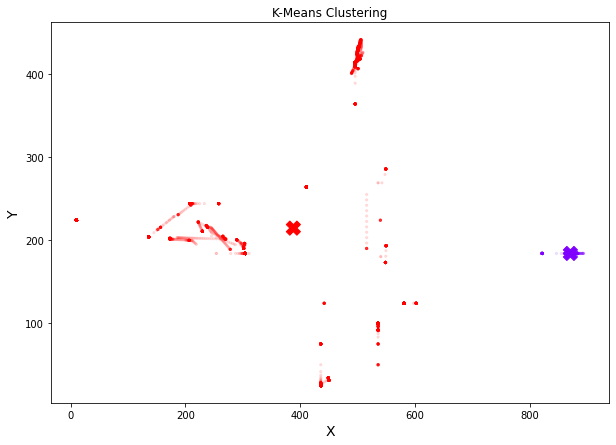

In [ ]:
# SETTING THE VALUE OF K
k = 2

start_time = time.time() # getting the current time
dist, cent = KMeans(df, k)
# Printing the elapsed time of selection sort using arrays as arguments
print("Time taken for clustering is:\
      --- %s seconds ---" % (time.time() - start_time))
print("\n")

x, y = [cent[i][0] for i in cent], [cent[i][1] for i in cent]

df.plot(kind="scatter", x = "X", y = "Y", alpha = 0.1,
    s = 5, figsize = (10,7), colorbar = False,
    c = np.array(dist)[:,-1], cmap = plt.get_cmap("rainbow"),
    sharex=False)

plt.scatter(x, y, marker='X', alpha = 1.0, c = [u for u in cent], cmap = plt.get_cmap("rainbow"), s = 200)

# plt.imshow(X, extent=[-124.55, -113.80, 32.45, 42.05], alpha = 0.3)
plt.ylabel("Y", fontsize=14)
plt.xlabel("X", fontsize=14)
plt.title('K-Means Clustering')

plt.show()


##cluster evaluation

In [ ]:
EVENT_ACCIDENT = 1
EVENT_STOP = 2
CLUSTER_BOUNDARY = 100          # A cluster's radius = distance between centroid and farthest point + CUSTER_BOUNDARY
CLUSTER_COLOR = (50, 50, 200)   # Bluish
CLUSTER_COLOR_VAR = 50
CLUSTER_WIDTH = 2                       # Line thickness
CLUSTER_MOVING_AVERAGE_WEIGHT = 0.1
BATCH_FONT_SIZE = 30
BATCH_NAME_COLOR = (255, 255, 255) # white

##Define distance functions

In [ ]:
def distance(x1, y1, time1, event1,\
                         x2, y2, time2, event2):
  
    return math.sqrt(distance_position(x1, y1, x2, y2)**2 +\
                            distance_time(time1, time2)**2 +\
                            distance_event(event1, event2)**2)

def distance_position(x1, y1, x2, y2):
    return math.sqrt((x1-x2)**2 + (y1-y2)**2)    

def distance_time(time1, time2):
    return math.sqrt((time1-time2)**2)

def distance_event(event1, event2):
    return math.sqrt((event1-event2)**2)

##Define a Report object


In [ ]:
class Report():
    def __init__(self, reporter, x, y, event):
        self.reporter = reporter
        self.x = x
        self.y = y        
        self.time = int(time.time()) # current time in seconds        
        self.event = event  
        
        

##Define a Cluster object

In [ ]:
class Cluster():
    def __init__(self, pygame, report):
        self.pygame = pygame
        self.x = report.x
        self.y = report.y
        self.time = report.time
        self.event = report.event
        self.reports = [report]
        self.radius = CLUSTER_BOUNDARY
        self.max_distance = 0
        self.color = report.reporter.color
        self.color = (CLUSTER_COLOR[0]+random.randrange(-CLUSTER_COLOR_VAR,CLUSTER_COLOR_VAR),
                      CLUSTER_COLOR[1]+random.randrange(-CLUSTER_COLOR_VAR,CLUSTER_COLOR_VAR),
                       CLUSTER_COLOR[2]+random.randrange(-CLUSTER_COLOR_VAR,CLUSTER_COLOR_VAR))
        
    def distance(self, report): 
        return distance(self.x, self.y, self.time, self.event,\
                         report.x, report.y,  report.time, report.event)

    def insert(self, report):
        self.reports.append(report)
        n = len(self.reports) - 1
        n_new = len(self.reports)
        self.x = (self.x * n + report.x) / n_new
        self.y = (self.y * n + report.y) / n_new
        self.time = (self.time * n + report.time) / n_new
        self.event = (self.event * n + report.event) / n_new
        max_distance = 0
        for r in self.reports:
            distance = self.distance(r)
            if max_distance < distance:
                max_distance = distance
        self.radius = max_distance + CLUSTER_BOUNDARY
        
        
    def include_report(self, report):
        distance_to_report = self.distance(report)
        return (distance_to_report <= self.radius, distance_to_report)

    def include_cluster(self, cluster):
        distance_to_cluster = distance(self.x, self.y, self.time, self.event,\
                         cluster.x, cluster.y, cluster.time, cluster.event)
        return distance_to_cluster <= self.radius

    def combine_with(self, cluster):
        # Extend report list
        self.reports.extend(cluster.reports)

        # Update x, y, time, and event as the average of all reports
        self.x = 0
        self.y = 0
        self.time = 0
        self.event = 0
        for report in self.reports:
            self.x += report.x
            self.y += report.y
            self.time += report.time
            self.event += report.event
        self.x = self.x / len(self.reports)
        self.y = self.y / len(self.reports)
        self.time = self.time / len(self.reports)
        self.event = self.event / len(self.reports)        
        # Update radius
        max_distance = 0
        for report in self.reports:
            distance = self.distance(report)
            if max_distance < distance:
                max_distance = distance
        self.radius = max_distance + CLUSTER_BOUNDARY

        # Update color with the average color of two clusters
        self.color = (int((self.color[0]+cluster.color[0])/2), int((self.color[1]+cluster.color[1])/2), int((self.color[2]+cluster.color[2])/2))
        
    def paint_on(self, screen):
        if len(self.reports) <= 10: # Show only significant clusters and exclude those with temporary congestion
            return

        # Draw a circle that represents this cluster
        self.pygame.draw.circle(screen, self.color, [self.x,self.y], self.radius, CLUSTER_WIDTH)

        # Show the number of reports that belong to this cluster
        font_report_num = self.pygame.font.SysFont(None, min(len(self.reports)+20,100))        
        report_num = font_report_num.render(str(len(self.reports)), True, self.color)
        screen.blit(report_num, (self.x, self.y))  
        
    def report_list(self, report): # returns list of reports
       return(report.Report(x))


In [ ]:
print(x)

[871.3098208136892, 388.2336478036584]


##Define a batch object

In [ ]:
class Batch():
    def __init__(self, pygame, batch_num, time_batch):
        self.pygame = pygame
        self.report_queue = []
        self.cluster_list = []
        self.batch_num = batch_num
        self.font_batch_num = pygame.font.SysFont(None, BATCH_FONT_SIZE)        
        self.begin_time = pygame.time.get_ticks()    # get time in milliseconds since pygame.init() was called
        self.end_time = self.begin_time + time_batch
        self.time_batch = time_batch
        
    def paint_on(self, screen):
        remaining_time = int((self.end_time - self.pygame.time.get_ticks())/1000) + 1        
        batch_num_object = self.font_batch_num.render("batch #" + str(self.batch_num) + " (" + str(remaining_time) + "/" + str(int(self.time_batch/1000)) + " secs remain)", True, BATCH_NAME_COLOR)
        screen.blit(batch_num_object, (0,0))
        for cluster in self.cluster_list:
            cluster.paint_on(screen)

    def report(self, car, event):
        self.report_queue.append(Report(car, car.rect.centerx, car.rect.centery, car.lane, event))
        #return Report(car, car.rect.centerx, car.rect.centery, car.lane, event) # i added
    #def report_list(self, car, event):
        #return Report()
    def process_reports(self):    
        for report in self.report_queue:
            min_distance = math.inf
            nearest_cluster = None
            for cluster in self.cluster_list:
                include, distance = cluster.include_report(report)
                if include and (distance < min_distance):
                    nearest_cluster = cluster
                    min_distance = distance
                    
            if nearest_cluster != None:
                # If a nearest cluster exists, push the report into the cluster
                nearest_cluster.insert(report)
            else:
                # Otherwise, create a new cluster with the report
                self.cluster_list.append(Cluster(self.pygame, report))
                self.report_queue.clear('nan')
                self.combine_clusters()  
                # callingcombinecluster()


In [ ]:
def combine_clusters(self):
 for cluster in self.cluster_list:
     cluster.combined = False      
 for i in range(0, len(self.cluster_list)-2):
     c1 = self.cluster_list[i]
     if c1.combined:
       continue            
     for j in range(i+1, len(self.cluster_list)-1):
       c2 = self.cluster_list[j]
       if c2.combined:
         continue                
       if c1.include_cluster(c2) or c2.include_cluster(c1):
         c1.combine_with(c2)
         c2.combined = True
         print("two clusters combined")
                    
     new_cluster_list = []
     for cluster in self.cluster_list:
        if not cluster.combined:
          new_cluster_list.append(cluster)
     self.cluster_list = new_cluster_list
 

##NEW self clusters 

In [ ]:
from sklearn.decomposition import PCA
from IPython import display
import matplotlib.cm as cm
from matplotlib.pyplot import savefig
#%matplotlib inline
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from itertools import cycle, islice
from pandas.plotting import parallel_coordinates

In [ ]:
data = pd.read_csv('/content/new_cluster_report.csv')
# data = pd.read_csv('/cluster_report.csv')
data=data.sort_values(by="TIME")

In [ ]:
print(data.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6239 entries, 0 to 6238
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   X       6239 non-null   float64
 1   Y       6239 non-null   float64
 2   TIME    6239 non-null   int64  
 3   EVENT   6239 non-null   int64  
dtypes: float64(2), int64(2)
memory usage: 243.7 KB
None


In [ ]:
features = ['X','Y','TIME']
select_df = data[features]
print(select_df.columns)

Index(['X', 'Y', 'TIME'], dtype='object')


In [ ]:
X = StandardScaler().fit_transform(select_df)

K-Mean


In [ ]:
def KMeans(X, K, maxIters=10):
 
    centroids = X[np.random.choice(np.arange(len(X)), K), :]
    for i in range(maxIters):
        # Cluster Assignment step
        C = np.array([np.argmin([np.dot(x_i - y_k, x_i - y_k)
                                 for y_k in centroids]) for x_i in X])
        # Move centroids step
        centroids = [X[C == k].mean(axis=0) for k in range(K)]
    return np.array(centroids), C

# test KMeans algorithm

centroids, C = KMeans(X, 3, 100)

pca = PCA(2)
X_pca = pca.fit_transform(X)
X_pca.shape

(6239, 2)

In [ ]:
start_time = time.time()

KMeans = KMeans(X, 3, 100)


print("Time taken for clustering using self k_MEANS is:\
      --- %s seconds ---" % (time.time() - start_time))
print("\n")

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: RuntimeWarning: Mean of empty slice.
  if __name__ == '__main__':
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:182: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)


Time taken for clustering using online k-means is:      --- 21.116989374160767 seconds ---




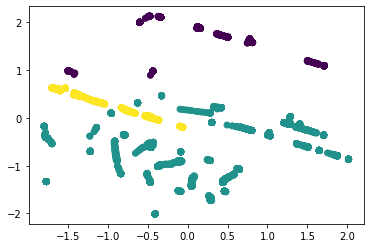

In [ ]:
plt.scatter(X_pca[:,0], X_pca[:, 1], c=C)

SELF_K_MEAN

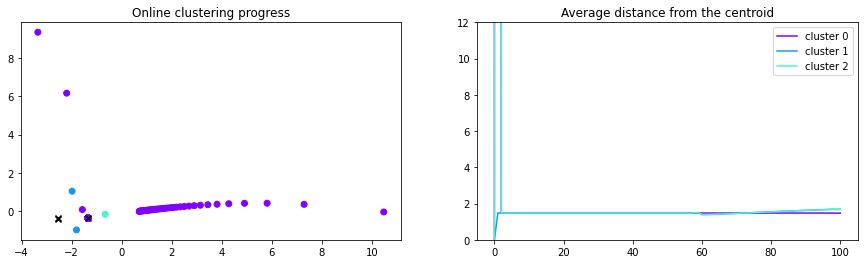

In [ ]:
class OnlineKMeans:

    def __init__(self, X, K=6, window_size=np.inf, plot_progress=False, add_remove=False,
                 threshold_create=np.inf, threshold_remove=np.inf, cold_start=False):
        self.X = X
        self.K = K
        self.window_size = window_size
        self.plot_progress = plot_progress
        self._nsamples = X.shape[0]
        self._dim = X.shape[1]
        self._eps = 1e-3
        self.threshold_create = threshold_create
        self.threshold_remove = threshold_remove
        self.add_remove = add_remove
        self.cold_start = cold_start
        plt.figure(figsize=(15, 4))

        if self._nsamples < K:
            print("Error")

    def _plot_progress(self, c, centroids):
        pca = PCA(2)
        pca.fit(self._X_norm)
        X_pca = pca.transform(self._X_norm)

        centroids_ = [centroids[i]
                      for i in range(len(centroids)) if i not in self._infidx]
        centroids_pca = pca.transform(centroids_)

        plt.clf()

        plt.subplot(121)
        plt.title('Online clustering progress')

        colors = cm.rainbow([0.2 * i for i in range(self.K)]).tolist()
        map_colors = [colors[k] for k in c]
        plt.scatter(X_pca[:, 0], X_pca[:, 1], c=map_colors)
        plt.scatter(centroids_pca[:, 0],
                    centroids_pca[:, 1], color='black', marker='x')

        plt.subplot(122)
        plt.title('Average distance from the centroid')
        plt.ylim(ymax=12)

        max_dim = np.max([len(self._mean_dist[i])
                          for i in range(len(self._mean_dist))])

        for i in range(len(self._mean_dist)):
            self._mean_dist[i].extend(
                [0] * (max_dim - len(self._mean_dist[i])))

        for k in range(self.K):
            plt.plot(np.array(self._mean_dist)[
                     :, k], color=colors[k], label='cluster ' + str(k))

        plt.legend()

        display.display(plt.gcf())
        display.clear_output(wait=True)
        plt.savefig('imagen.pdf')

    def data_stream(self):
        """
        Simulate data streaming
        """
        yield from self.X

    def distance(self, x, y, method='euclidean'):
        if method is 'euclidean':
            return np.sqrt(np.dot(x - y, x - y))
        else:
            print('%s distance unknown' % method)

    def update_centroids(self, gamma, data_point, centroid):
        return (centroid + gamma * (data_point - centroid))

    def add_cluster(self):
        self.K += 1

    def run(self, max_iter=100):
        
        stream = self.data_stream()
        C = list(range(self.K))
        
        if self.cold_start:
            centroids = np.random.multivariate_normal(np.zeros(self._dim), np.eye(self._dim), self.K)            
            init = 0
            
        else:
            centroids = np.array([next(stream) for _ in range(self.K)])
            init = self.K
        
        
        # To normalize data on the fly
        mean = np.mean(centroids, axis=0)
        sigma = np.std(centroids, axis=0)
        centroids = (centroids - mean) / (sigma + self._eps)

        # auxiliary vectors only for plotting purposes
        self._X_norm = list(centroids)
        self._mean_dist = [[0] * self.K]
        self._infidx = []

        for t in range(init, min(self._nsamples, max_iter)):
            p = next(stream)

            mean_new = (t * mean + p) / (t + 1)
            sigma_new = np.sqrt(
                (sigma**2 * t + (p - mean) * (p - mean_new)) / (t + 1))

            normalized_p = (p - mean_new) / (sigma_new + self._eps)
            centroids = (centroids * sigma + mean - mean_new) / (sigma_new + self._eps)

            if self.add_remove:
                idx = np.argmin([self.distance(normalized_p, c)
                                 for c in centroids])

                # Condition to add a new cluster
                if self.distance(normalized_p, centroids[idx]) > self.threshold_create:
                    C.append(self.K)
                    self.add_cluster()
                    centroids = np.append(centroids, [normalized_p], axis=0)

                # Condition to remove cluster
                else:
                    while t - np.max(np.where(C == idx)) > self.threshold_remove:
                        centroids[idx] = np.inf * np.ones(self._dim)
                        self._infidx.append(idx)
                        idx = np.argmin([self.distance(normalized_p, c)
                                         for c in centroids])

                    C.append(
                        np.argmin([self.distance(normalized_p, c) for c in centroids]))

                    if self.window_size < t:
                        centroids[C[-1]] = self.update_centroids(1 / self.window_size,
                                                                 normalized_p, centroids[C[-1]])

                    else:
                        centroids[C[-1]] = self.update_centroids(1 / (t+1),
                                                                 normalized_p, centroids[C[-1]])

            else:
                C.append(
                    np.argmin([self.distance(normalized_p, c) for c in centroids]))

                if self.window_size < t:
                    centroids[C[-1]] = self.update_centroids(1 / self.window_size,
                                                             normalized_p, centroids[C[-1]])
                else:
                    centroids[C[-1]] = self.update_centroids(1 / (t+1),
                                                             normalized_p, centroids[C[-1]])

            # Update mean and sigma
            mean = mean_new
            sigma = sigma_new
                    
            # We save the normalized points and mean distance only for plotting purposes
            self._X_norm.append(normalized_p)
            self._mean_dist.append([np.mean([self.distance(
                p, centroids[k]) for p in self._X_norm[C == k]], axis=0) for k in range(self.K)])

            if self.plot_progress:
                self._plot_progress(C, centroids)

        return np.array(centroids), C

#getting current time
start_time = time.time()

online_kmeans = OnlineKMeans(X, 3, plot_progress=True,
                            add_remove=True, cold_start=True)

centroids, c = online_kmeans.run(max_iter=100)
print("Time taken for clustering using online k-means is:\
      --- %s seconds ---" % (time.time() - start_time))
print("\n")

In [ ]:
def k_means(data, k, threshhold=4):
    n = np.size(data, 0)
    # random initial assignment of clusters
    cluster_centers = np.random.choice(range(0, n), k)
    clustering = np.random.randint(0, k, n)
    cluster_means = data[cluster_centers]
    old_clustering = np.zeros(n)
    # while the clustering has not converged ... 
    while np.sum(clustering != old_clustering) > threshhold:
        # print np.sum(clustering != old_clustering)
        old_clustering = clustering

        # step 1: Assign points to clusters
        cluster_distances = np.zeros((n, k))
        for cluster in range(k):
            cluster_distances[:, cluster] = np.sum(np.sqrt((data - cluster_means[cluster])**2), 1)
        clustering = np.argmin(cluster_distances, 1)

        # step 2: re-calculating means
        # cluster_means should be a k x d array
        cluster_means = np.array([np.mean(data[clustering==c],0) for c in range(k)])
    return clustering

def k_means_update(point, k, cluster_means, cluster_counts):
  
    cluster_distances = np.zeros(k)
    for cluster in range(k):
        cluster_distances[cluster] = sum(np.sqrt((point - cluster_means[cluster])**2))
    c = np.argmin(cluster_distances)
    cluster_counts[c] += 1
    cluster_means[c] += 1.0/cluster_counts[c]*(point - cluster_means[c])
    return c

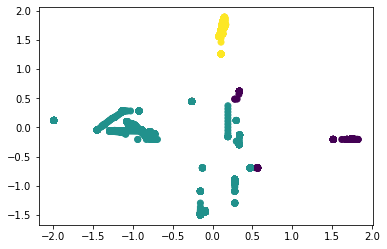

In [ ]:
plt.scatter(X[:,0], X[:, 1], c=C)

In [ ]:
print(c)

[0, 1, 2, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0]


In [ ]:
start_time = time.time()

K_Means = k_means(X,3,4)


print("Time taken for clustering using online k-means is:\
      --- %s seconds ---" % (time.time() - start_time))
print("\n")

Time taken for clustering using online k-means is:      --- 0.017642736434936523 seconds ---




##evaluation score of kmean

In [ ]:
from sklearn.datasets import load_digits
digits = load_digits()

In [ ]:
import numpy as np
import pandas as pd
from sklearn.datasets import load_digits
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.cluster import KMeans
from sklearn.metrics import accuracy_score

class clust():
    def _load_data(self, sklearn_load_ds):
        data = sklearn_load_ds
        X = pd.DataFrame(data.data)
        self.X_train, self.X_test, self.y_train, self.y_test = train_test_split(X, data.target, test_size=0.3, random_state=42)
        
        
    def __init__(self, sklearn_load_ds):
        self._load_data(sklearn_load_ds)
    
    
    def classify(self, model=LogisticRegression(random_state=42)):
        model.fit(self.X_train, self.y_train)
        y_pred = model.predict(self.X_test)
        print('Accuracy: {}'.format(accuracy_score(self.y_test, y_pred)))


    def Kmeans(self, output='add'):
        n_clusters = len(np.unique(self.y_train))
        clf = KMeans(n_clusters = n_clusters, random_state=42)
        clf.fit(self.X_train)
        y_labels_train = clf.labels_
        y_labels_test = clf.predict(self.X_test)
        if output == 'add':
            self.X_train['km_clust'] = y_labels_train
            self.X_test['km_clust'] = y_labels_test
        elif output == 'replace':
            self.X_train = y_labels_train[:, np.newaxis]
            self.X_test = y_labels_test[:, np.newaxis]
        else:
            raise ValueError('output should be either add or replace')
        return self


In [ ]:
clust(load_digits()).Kmeans(output='replace').classify(model=SVC())

Accuracy: 0.7833333333333333


In [ ]:
clust(load_digits()).classify()

Accuracy: 0.9648148148148148


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


In [ ]:
clust(load_digits()).Kmeans(output='add').classify(model=SVC())

Accuracy: 0.9888888888888889


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,


In [ ]:
x=data
kmeans5 = k_means(X,3,4)
print(kmeans5)

[0 0 0 ... 2 1 1]


###SELF_CLUSTER EVULATION

# New Section

In [ ]:
!pip install  yellowbrick 

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import numpy as nm    
import matplotlib.pyplot as mtp    
import pandas as pd  
from sklearn.cluster import KMeans  

In [ ]:
df = pd.read_csv('/content/new_cluster_report.csv')
print(df)


          X      Y        TIME  EVENT
0     258.0  244.0  1653544822      1
1     258.0  244.0  1653544822      1
2     258.0  244.0  1653544822      1
3     258.0  244.0  1653544822      1
4     258.0  244.0  1653544822      1
...     ...    ...         ...    ...
6234  872.0  184.0  1653544954      2
6235  536.0  100.0  1653544954      2
6236  496.0  414.0  1653544956      2
6237  208.0  244.0  1653544956      2
6238  436.0   25.0  1653544956      2

[6239 rows x 4 columns]


In [ ]:
x = df.iloc[:, [2]].values  

In [ ]:
df=df.sort_values(by="TIME")

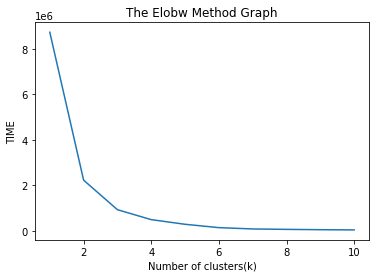

In [ ]:
wcss_list= []  #Initializing the list for the values of WCSS  
  
#Using for loop for iterations from 1 to 10.  
for i in range(1, 11):  
    kmeans = KMeans(n_clusters=i, init='k-means++', random_state= 42)  
    kmeans.fit(x)  
    wcss_list.append(kmeans.inertia_)  
mtp.plot(range(1, 11), wcss_list)  
mtp.title('The Elobw Method Graph')  
mtp.xlabel('Number of clusters(k)')  
mtp.ylabel('TIME')  
mtp.show()  

In [ ]:
# Importing the required libraries
import pandas as pd
import numpy as np

from sklearn.preprocessing import StandardScaler
import seaborn as sns
from matplotlib import pyplot as plt
from sklearn.cluster import KMeans
import matplotlib.cm as cm
from sklearn.metrics import silhouette_score, silhouette_samples
from yellowbrick.cluster import silhouette_visualizer

In [ ]:
df = pd.read_csv('/content/new_cluster_report.csv')

In [ ]:

df.head()

,X,Y,TIME,EVENT
0,258.0,244.0,1653544822,1
1,258.0,244.0,1653544822,1
2,258.0,244.0,1653544822,1
3,258.0,244.0,1653544822,1
4,258.0,244.0,1653544822,1


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6239 entries, 0 to 6238
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   X       6239 non-null   float64
 1   Y       6239 non-null   float64
 2   TIME    6239 non-null   int64  
 3   EVENT   6239 non-null   int64  
dtypes: float64(2), int64(2)
memory usage: 195.1 KB


In [ ]:
numericalColumns = ['X', 'Y', 'TIME','EVENT']
categoricalColumns = ['EVENT']
categoricalColumn = ['TIME']
has=['X','Y']
# categoricalColumns=categoricalColumns.sort_values(by="TIME")

In [ ]:
numericalColumns

['X', 'Y', 'TIME', 'EVENT']

In [ ]:
df.loc[:,has].describe()

,X,Y
count,6239.000000,6239.000000
mean,471.391816,209.224608
std,231.637236,122.789967
min,10.000000,25.000000
25%,303.146667,124.000000
50%,496.000000,184.000000
75%,548.812500,244.000000
max,894.500000,441.486911


In [ ]:
df.loc[:,numericalColumns].describe()

,X,Y,TIME,EVENT
count,6239.000000,6239.000000,6.239000e+03,6239.000000
mean,471.391816,209.224608,1.653545e+09,1.856548
std,231.637236,122.789967,3.740362e+01,0.350562
min,10.000000,25.000000,1.653545e+09,1.000000
25%,303.146667,124.000000,1.653545e+09,2.000000
50%,496.000000,184.000000,1.653545e+09,2.000000
75%,548.812500,244.000000,1.653545e+09,2.000000
max,894.500000,441.486911,1.653545e+09,2.000000


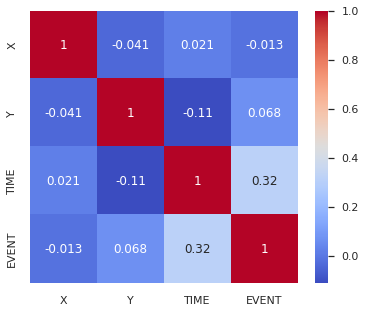

In [ ]:
corrMatrix = df.loc[:,numericalColumns].corr()

sns.set(rc={'figure.figsize':(6,5)})
sns.heatmap(corrMatrix, cmap = 'coolwarm', annot = True)
plt.show()

In [ ]:
categoricalColumn=df.loc[:,categoricalColumn].sort_values(by="TIME")

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


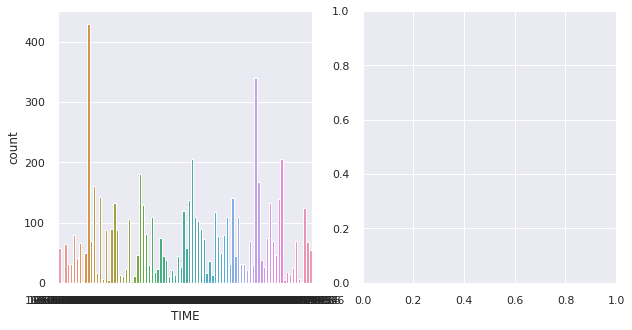

In [ ]:
# Visualizing distribution of categorical columns
import seaborn as sns
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
for variable, subplot in zip(categoricalColumn, ax.flatten()):
    sns.countplot(df[variable], ax=subplot)
    for label in subplot.get_xticklabels():
        label.set_rotation(0)

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


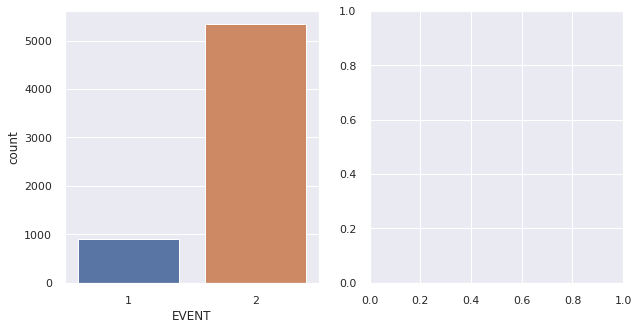

In [ ]:
# Visualizing distribution of categorical columns
import seaborn as sns
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
for variable, subplot in zip(categoricalColumns, ax.flatten()):
    sns.countplot(df[variable], ax=subplot)
    for label in subplot.get_xticklabels():
        label.set_rotation(0)

In [ ]:
data = pd.get_dummies(data=df, columns=categoricalColumns)
data.head()

,X,Y,TIME,EVENT_1,EVENT_2
0,258.0,244.0,1653544822,1,0
1,258.0,244.0,1653544822,1,0
2,258.0,244.0,1653544822,1,0
3,258.0,244.0,1653544822,1,0
4,258.0,244.0,1653544822,1,0


In [ ]:
# Scaling data with the help of standard scaler
scaler = StandardScaler()
scaler.fit(data)
scaled_data = scaler.transform(data)

In [ ]:
scaled_data

array([[-0.92130662,  0.28323307, -1.99160468,  2.44355268, -2.44355268],
       [-0.92130662,  0.28323307, -1.99160468,  2.44355268, -2.44355268],
       [-0.92130662,  0.28323307, -1.99160468,  2.44355268, -2.44355268],
       ...,
       [ 0.10624439,  1.66782197,  1.59122326, -0.4092402 ,  0.4092402 ],
       [-1.13717868,  0.28323307,  1.59122326, -0.4092402 ,  0.4092402 ],
       [-0.15280208, -1.50044322,  1.59122326, -0.4092402 ,  0.4092402 ]])

In [64]:
x = scaled_data.copy()

For n_clusters = 2 The average silhouette_score is : 0.5363168160740954
For n_clusters = 3 The average silhouette_score is : 0.38032116329299787
For n_clusters = 4 The average silhouette_score is : 0.4501921660451924
For n_clusters = 5 The average silhouette_score is : 0.516414178209537
For n_clusters = 6 The average silhouette_score is : 0.5230380020138706
For n_clusters = 7 The average silhouette_score is : 0.5372092277051859
For n_clusters = 8 The average silhouette_score is : 0.5556694155537474
For n_clusters = 9 The average silhouette_score is : 0.5707318723749959
For n_clusters = 10 The average silhouette_score is : 0.5832198137309587


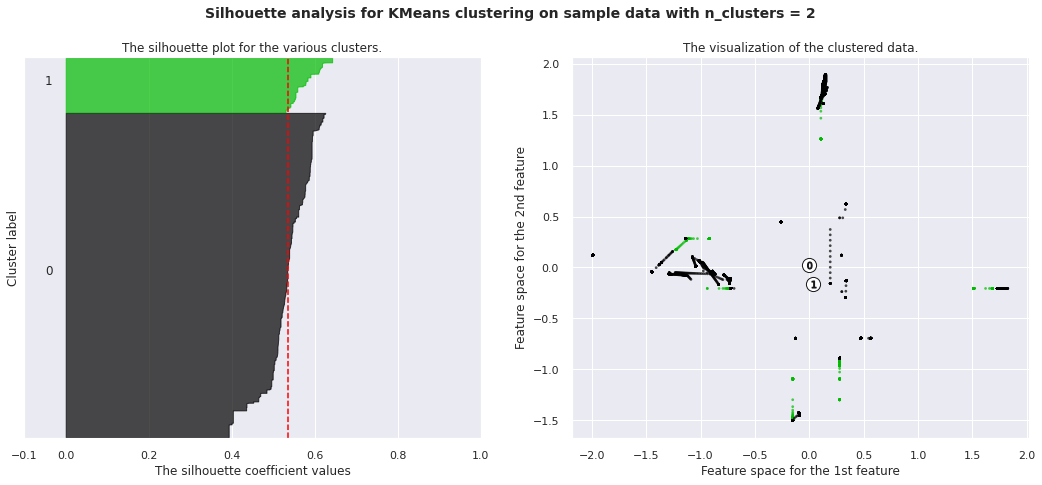

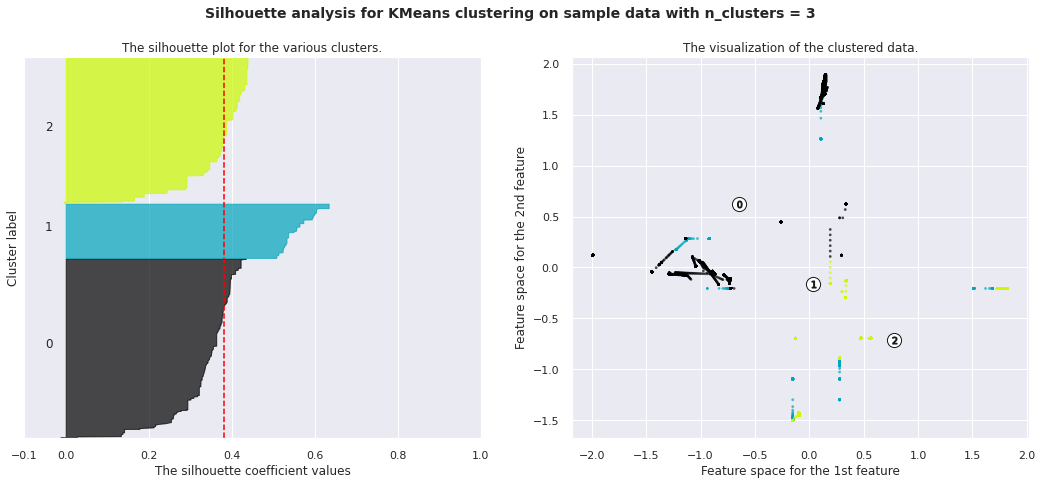

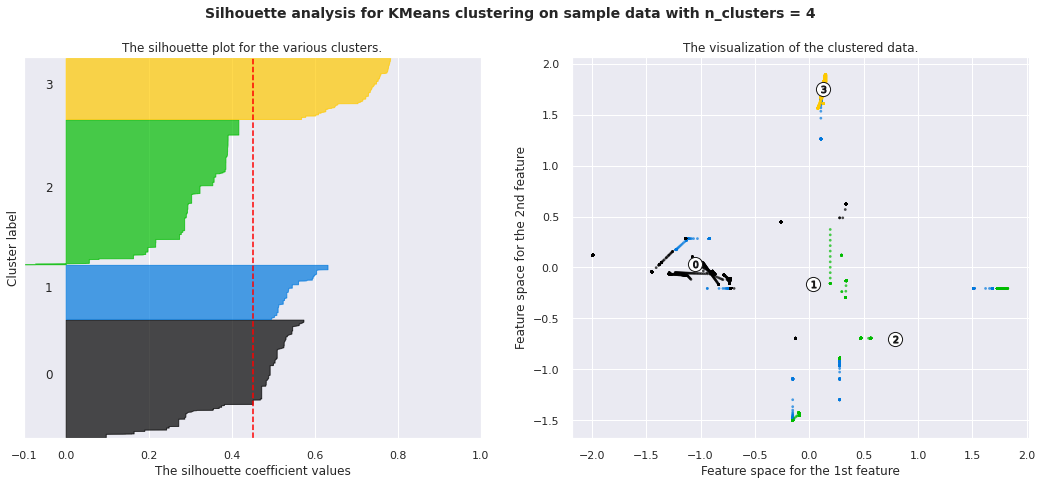

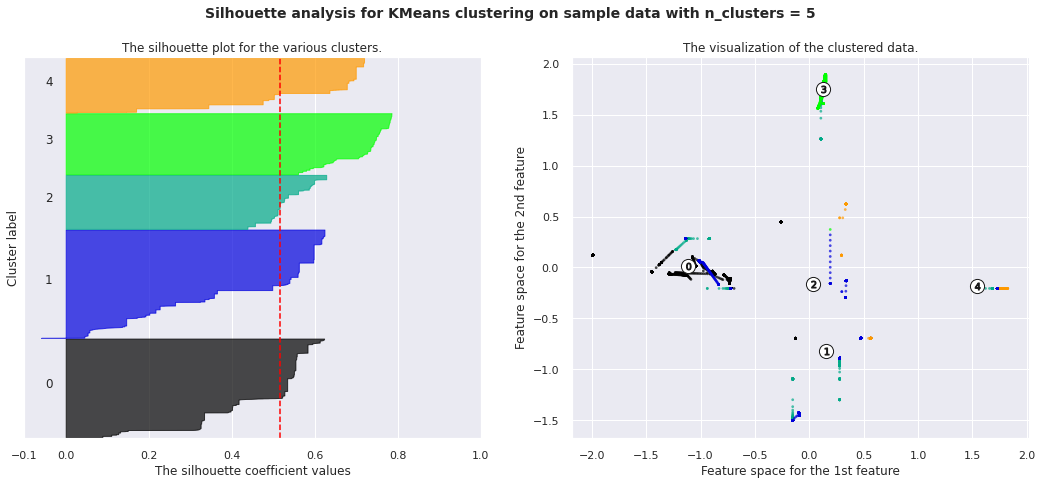

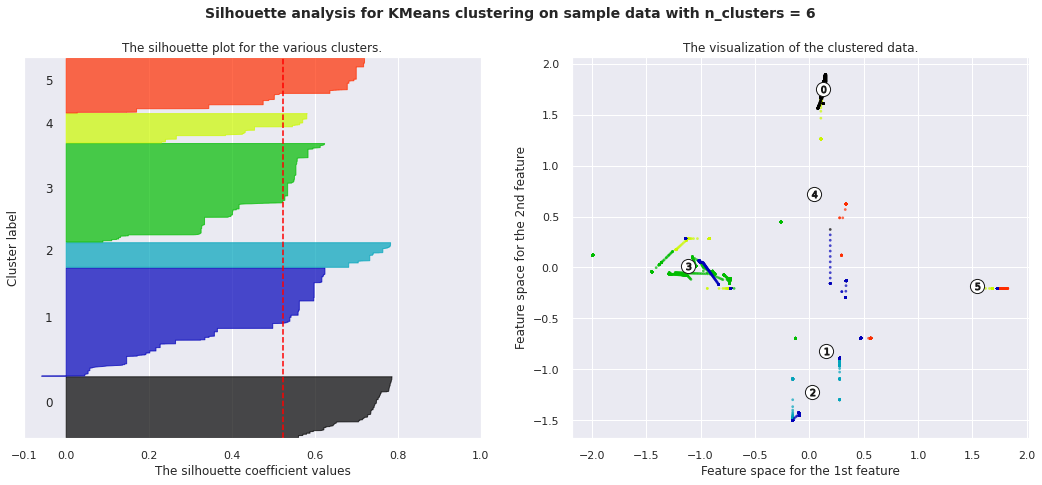

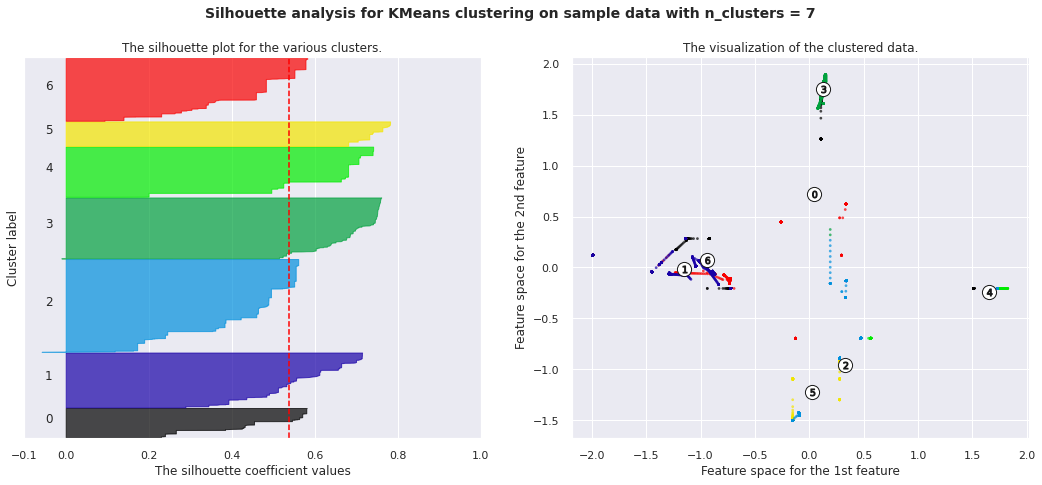

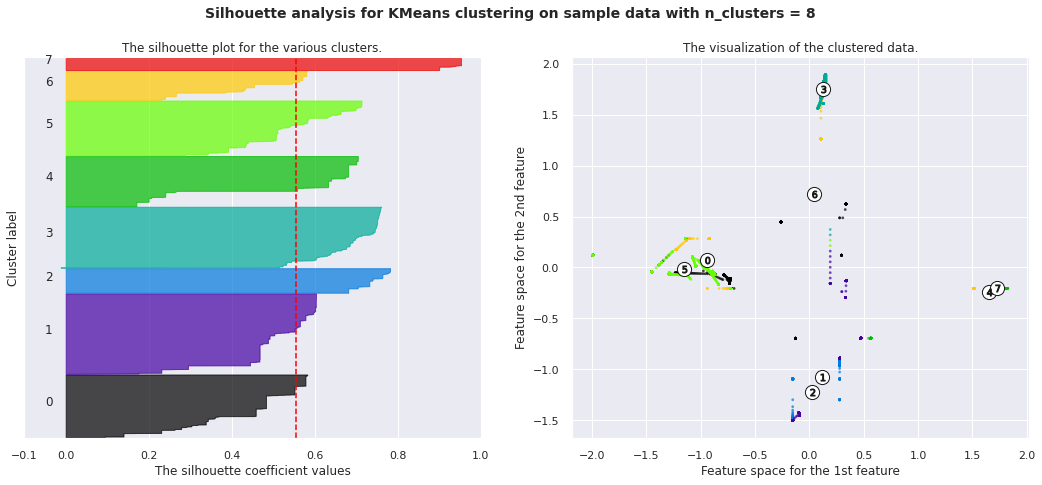

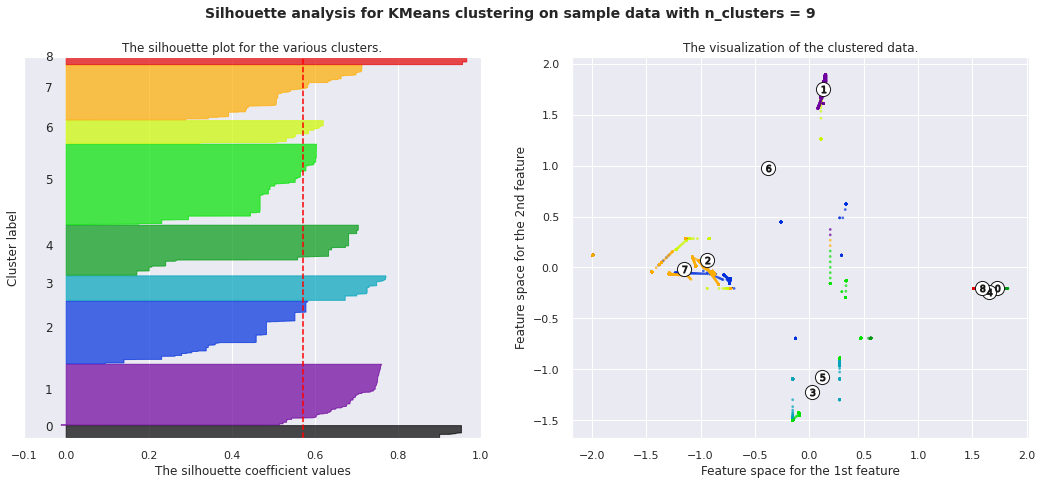

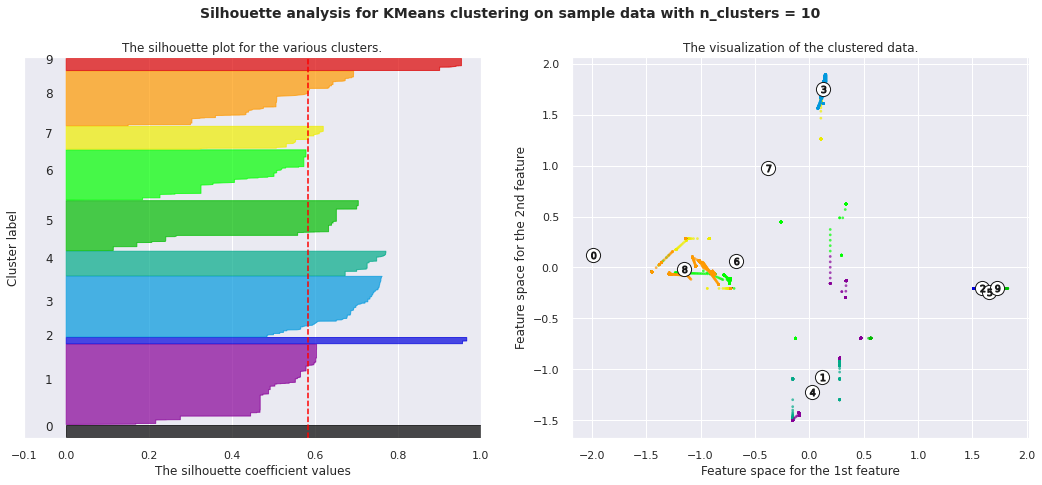

In [65]:

for n_clusters in range(2,11):
    # Create a subplot with 1 row and 2 columns
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(18, 7)

    # The 1st subplot is the silhouette plot
    # The silhouette coefficient can range from -1, 1 but in this example all
    # lie within [-0.1, 1]
    ax1.set_xlim([-0.1, 1])
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax1.set_ylim([0, len(x) + (n_clusters + 1) * 10])

    # Initialize the clusterer with n_clusters value and a random generator
    # seed of 10 for reproducibility.
    clusterer = k_means(X,3,4)
    clusterers = KMeans(n_clusters=n_clusters, random_state=10)
    cluster_labels = clusterers.fit_predict(x)
    

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg = silhouette_score(x, cluster_labels)
    print("For n_clusters =", n_clusters,
          "The average silhouette_score is :", silhouette_avg)

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(x, cluster_labels)

    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = \
            sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    # 2nd Plot showing the actual clusters formed
    colors = cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)
    ax2.scatter(x[:, 0], x[:, 1], marker='.', s=30, lw=0, alpha=0.7,
                c=colors, edgecolor='k')

    # Labeling the clusters
    centers = clusterers.cluster_centers_
    # Draw white circles at cluster centers
    ax2.scatter(centers[:, 0], centers[:, 1], marker='o',
                c="white", alpha=1, s=200, edgecolor='k')

    for i, c in enumerate(centers):
        ax2.scatter(c[0], c[1], marker='$%d$' % i, alpha=1,
                    s=50, edgecolor='k')

    ax2.set_title("The visualization of the clustered data.")
    ax2.set_xlabel("Feature space for the 1st feature")
    ax2.set_ylabel("Feature space for the 2nd feature")

    plt.suptitle(("Silhouette analysis for self_KMeans clustering on sample data "
                  "with n_clusters = %d" % n_clusters),
                 fontsize=14, fontweight='bold')

plt.show()

In [62]:
silhouette = []
for n_clusters in range(2,9):
    n_clusters=n_clusters
    clusterer = k_means(x,3,4)
    clusterers = KMeans(n_clusters=n_clusters, random_state=10)
    preds = clusterers.fit_predict(scaled_data)
    score = silhouette_score(scaled_data, preds)
    silhouette.append(score)
    print("For n_clusters = {}, silhouette score is {})".format(n_clusters, score))

For n_clusters = 2, silhouette score is 0.5363168160781939)
For n_clusters = 3, silhouette score is 0.3803211633076299)
For n_clusters = 4, silhouette score is 0.45019216606306456)
For n_clusters = 5, silhouette score is 0.5164141782634013)
For n_clusters = 6, silhouette score is 0.5230380020677349)
For n_clusters = 7, silhouette score is 0.5372092277698761)
For n_clusters = 8, silhouette score is 0.5556694156421282)


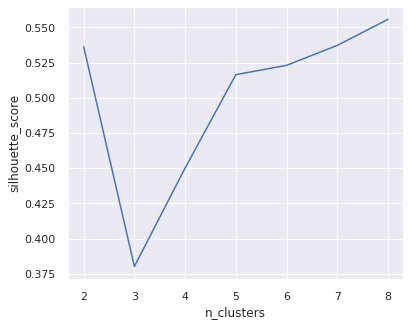

In [63]:
from sklearn.metrics import silhouette_score
n_clusters = [x for x in range(2,9)]
df_silhouette = pd.DataFrame({'n_clusters':n_clusters,'silhouette_score':silhouette})
sns.lineplot(data=df_silhouette, x="n_clusters", y="silhouette_score")